In [63]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def moving_average(data, window_size):
    """Compute the moving average of a 1D array."""
    kernel = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, kernel, mode='valid')
    return smoothed_data


def trigger_signal_on_peaks(peaks, original_signal, trigger_signal, trigger_window_before, trigger_window_after):
    triggered_signals = []
    
    for peak in peaks:
        start_index = max(0, peak - trigger_window_before)
        end_index = min(len(original_signal), peak + trigger_window_after + 1)
        
        trigger_start = max(0, trigger_window_before - (peak - start_index))
        trigger_end = min(len(trigger_signal), trigger_start + end_index - start_index, trigger_window_before + trigger_window_after)
        
        triggered_signal = np.zeros(trigger_window_before + trigger_window_after)
        triggered_signal[trigger_start:trigger_end] = trigger_signal[start_index:start_index + trigger_end - trigger_start]
        triggered_signals.append(triggered_signal)
    
    return np.array(triggered_signals)


In [64]:
json_dir = "./data/annotations/rotifer-pose.v5i.coco/"
json_files = glob.glob(os.path.join(json_dir, '**/*.json'), recursive=True)

In [65]:
# filtered_images = []

# for json_file in json_files:
#     with open(json_file, 'r') as f:
#         json_data = json.load(f)
        
#         for image in json_data["images"]:
#             if "extra" in image:
#         # Check if "user_tags" field is present in "extra" and if "v91" is in the user tags
#                 if "user_tags" in image["extra"] and "v91" in image["extra"]["user_tags"]:
#                     filtered_images.append(image)

In [66]:
df = pd.DataFrame()

for json_file in json_files:
    with open(json_file, 'r') as f:
        json_data = json.load(f)

        image_ids = [image['id'] for image in json_data['images']]
        file_names = [image['file_name'] for image in json_data['images']]
        file_names = [fn.split("_jpg")[0] for fn in file_names]
        
        keypoints_list = []
        for annotation in json_data["annotations"]:
            keypoints = annotation.get("keypoints", [])
            if len(keypoints) >= 6:
                x1, y1, visibility1, x2, y2, visibility2 = keypoints[:6]
                keypoints_list.append((x1, y1, visibility1, x2, y2, visibility2))
        
        d = {"ids" : image_ids, "file_names" : file_names,
            "x1" : [i[0] for i in keypoints_list],
            "y1" : [i[1] for i in keypoints_list],
            "v1" : [i[2] for i in keypoints_list],
            "x2" : [i[3] for i in keypoints_list],
            "y2" : [i[4] for i in keypoints_list],
            "v2" : [i[5] for i in keypoints_list]}

        df_loop = pd.DataFrame.from_dict(d)
        df = pd.concat([df, df_loop])

df = df.sort_values(by="file_names")
df.describe()

,ids,x1,y1,v1,x2,y2,v2
count,315.000000,315.000000,315.000000,315.0,315.000000,315.000000,315.0
mean,84.850794,759.593676,785.999244,2.0,435.234956,593.786416,2.0
std,66.689412,219.122505,187.122638,0.0,96.357739,228.151445,0.0
min,0.000000,420.135000,366.277000,2.0,240.150000,236.260000,2.0
25%,26.000000,567.804500,636.312000,2.0,372.139000,295.806500,2.0
50%,63.000000,748.107000,794.333000,2.0,460.132000,740.326000,2.0
75%,141.500000,966.412000,944.132000,2.0,468.131000,782.331000,2.0
max,220.000000,1402.052000,1078.370000,2.0,1054.081000,804.334000,2.0


In [67]:
json_data['images']

[{'id': 0,
  'license': 1,
  'file_name': 'frame_00250_jpg.rf.fc95fde09a06ed3c016bddcf2cd14847.jpg',
  'height': 1084,
  'width': 1668,
  'date_captured': '2024-04-24T11:19:21+00:00',
  'extra': {'user_tags': ['v91']}},
 {'id': 1,
  'license': 1,
  'file_name': 'frame_00048_jpg.rf.fb4e7266c3ba1bea9e966ed2bea6e8f3.jpg',
  'height': 1084,
  'width': 1668,
  'date_captured': '2024-04-24T11:19:21+00:00',
  'extra': {'user_tags': ['v91']}},
 {'id': 2,
  'license': 1,
  'file_name': 'frame_00096_jpg.rf.046ac541caa6571699c97582ee91a93b.jpg',
  'height': 1084,
  'width': 1668,
  'date_captured': '2024-04-24T11:19:21+00:00',
  'extra': {'user_tags': ['v91']}},
 {'id': 3,
  'license': 1,
  'file_name': 'frame_00116_jpg.rf.0253cd9d79832917f6739a57f26e8bc1.jpg',
  'height': 1084,
  'width': 1668,
  'date_captured': '2024-04-24T11:19:21+00:00',
  'extra': {'user_tags': ['v91']}},
 {'id': 4,
  'license': 1,
  'file_name': 'frame_00152_jpg.rf.06f69e7b63310b622832a27777d9d4ad.jpg',
  'height': 1084,
 

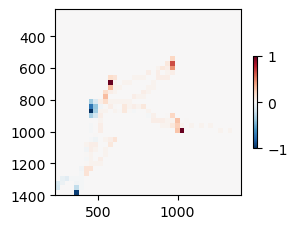

In [68]:
bins = 40
x_bins, y_bins = np.linspace(230, 1400, bins), np.linspace(230, 1400, bins)

hist_f, x_edges, y_edges = np.histogram2d(df.x1.to_numpy(), df.y1.to_numpy(), bins=[x_bins, y_bins])
hist_b, x_edges, y_edges = np.histogram2d(df.x2.to_numpy(), df.y2.to_numpy(), bins=[x_bins, y_bins])

ccmap = "RdBu_r"  # "bwr" #
norm = mcolors.Normalize(vmin=-1, vmax=1)
normf = hist_f / hist_f.max()
normb = -1 * (hist_b / hist_b.max())
mat = normf + normb

plt.figure(figsize=(3,3))
plt.imshow(mat.T, norm=norm, cmap=ccmap, interpolation='nearest', origin="lower", extent=[230, 1400, 1400, 230]) #, origin='upper'
#plt.imshow(hist_f / hist_f.max(), norm=norm, cmap=ccmap, alpha=0.5, interpolation='nearest')
#plt.imshow(-1 * (hist_b / hist_b.max()), norm=norm, cmap=ccmap, alpha=0.5, interpolation='nearest')
plt.colorbar(shrink=.4)

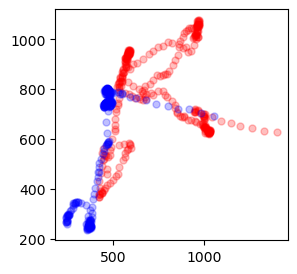

In [69]:
plt.figure(figsize=(3,3))
plt.plot(df.x1, df.y1, "or", label="front", alpha=.25, ms=5)
plt.plot(df.x2, df.y2, "ob", label="back", alpha=.25, ms=5)

- blue and red density plot
- dwell time
- anchored, elongated sampling, anchored > take off

<BarContainer object of 39 artists>

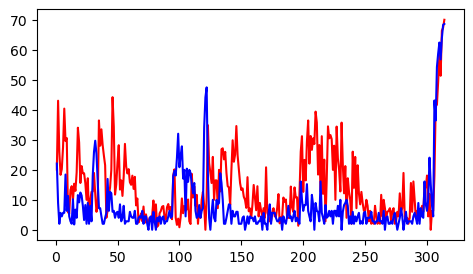

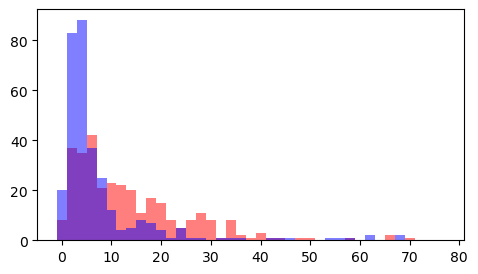

In [70]:
dxy1 = np.sqrt(df.x1.diff().to_numpy() ** 2 + df.y1.diff().to_numpy() ** 2)
dxy2 = np.sqrt(df.x2.diff().to_numpy() ** 2 + df.y2.diff().to_numpy() ** 2)
t = np.arange(0, len(dxy1), 1)

plt.figure(figsize=(5.5,3))
plt.plot(t, dxy1, "-r", label="front")
plt.plot(t, dxy2, "-b", label="back")

# hist
bins = np.arange(0, 80, 2)
countf = np.histogram(dxy1, bins=bins)[0]
countb = np.histogram(dxy2, bins=bins)[0]

plt.figure(figsize=(5.5,3))
plt.bar(bins[:-1], countf, color="r", width=2, label="front", alpha=.5)
plt.bar(bins[:-1], countb, color="b", width=2, label="back", alpha=.5)

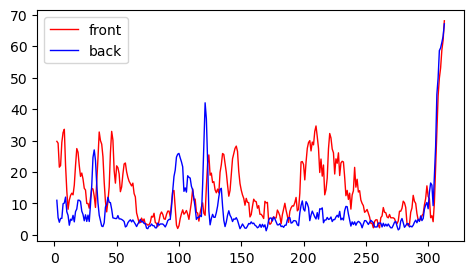

In [71]:
smooth_dxy1 = moving_average(dxy1, 3)
smooth_dxy2 = moving_average(dxy2, 3)
dist = np.sqrt((df.x1 - df.x2) ** 2 + (df.y1 - df.y2) ** 2)


plt.figure(figsize=(5.5,3))
plt.plot(t[1:-1], smooth_dxy1, "-r", label="front", lw=1)
plt.plot(t[1:-1], smooth_dxy2, "-b", label="back", lw=1)
#plt.plot(t, dist, "-k", label="dist", lw=1)
plt.legend()

# this is in pixels!!! > make it µm

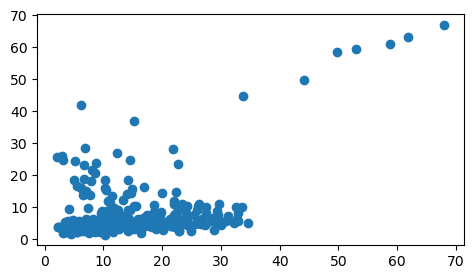

In [72]:
plt.figure(figsize=(5.5,3))
plt.plot(smooth_dxy1, smooth_dxy2, "o")

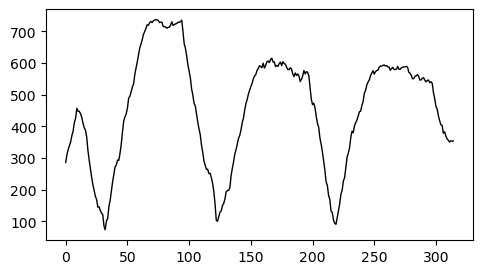

In [73]:
plt.figure(figsize=(5.5,3))
plt.plot(t, dist, "-k", label="front", lw=1)

In [ ]:
json_data["annotations"]

## Extract keypoints

In [ ]:
# keypoints_list = []

# for annotation in json_data["annotations"]:
#     keypoints = annotation.get("keypoints", [])
#     if len(keypoints) >= 6:
#         x1, y1, visibility1, x2, y2, visibility2 = keypoints[:6]
#         keypoints_list.append((x1, y1, visibility1, x2, y2, visibility2))

## Extract Filenames and ids

In [ ]:
# image_ids = [image['id'] for image in json_data['images']]
# file_names = [image['file_name'] for image in json_data['images']]
# file_names = [fn.split("_jpg")[0] for fn in file_names]

# print(len(image_ids), len(file_names), len(keypoints_list))

# Adineta

In [ ]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

def moving_average(data, window_size):
    """Compute the moving average of a 1D array."""
    kernel = np.ones(window_size) / window_size
    smoothed_data = np.convolve(data, kernel, mode='valid')
    return smoothed_data


In [ ]:
json_dir = "./data/annotations/rotifer-pose.v6i.coco/"
json_files = glob.glob(os.path.join(json_dir, '**/*.json'), recursive=True)

In [ ]:
adineta_id = {0 : [], 1 : [], 2 : []}

for nth, json_file in enumerate(json_files):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
        
        for image in json_data["images"]:
            if "extra" in image:
                if "user_tags" in image["extra"] and "adineta" in image["extra"]["user_tags"]:
                    adineta_id[int(nth)].append(image["id"])

adineta_id

In [ ]:
#image_ids = []
#file_names = []

df = pd.DataFrame()

for nth, json_file in enumerate(json_files):
    image_ids = []
    file_names = []
    keypoints_list = []
    
    with open(json_file, 'r') as f:
        json_data = json.load(f)
        #keypoints_list = []
        for adineta_index in adineta_id[int(nth)]:
            image = json_data["images"][adineta_index]
            
            image_ids.append(image['id'])
            file_names.append(image['file_name'].split("_jpg")[0])
            
            
            #for annotation in json_data["annotations"]:
            annotation = json_data["annotations"][adineta_index]
            keypoints = annotation.get("keypoints", [])
            if len(keypoints) >= 6:
                x1, y1, visibility1, x2, y2, visibility2 = keypoints[:6]
                keypoints_list.append((x1, y1, visibility1, x2, y2, visibility2))

        d = {"ids" : image_ids, "file_names" : file_names,
                "x1" : [i[0] for i in keypoints_list],
                "y1" : [i[1] for i in keypoints_list],
                "v1" : [i[2] for i in keypoints_list],
                "x2" : [i[3] for i in keypoints_list],
                "y2" : [i[4] for i in keypoints_list],
                "v2" : [i[5] for i in keypoints_list]}

        df_loop = pd.DataFrame.from_dict(d)
        df = pd.concat([df, df_loop])

df = df.sort_values(by="file_names")
df.describe()

In [ ]:
plt.figure(figsize=(3,3))
plt.plot(df.x1, df.y1, "or", label="front", alpha=.25, ms=5)
plt.plot(df.x2, df.y2, "ob", label="back", alpha=.25, ms=5)

In [ ]:
dxy1 = np.sqrt(df.x1.diff().to_numpy() ** 2 + df.y1.diff().to_numpy() ** 2)
dxy2 = np.sqrt(df.x2.diff().to_numpy() ** 2 + df.y2.diff().to_numpy() ** 2)
t = np.arange(0, len(dxy1), 1)

plt.figure(figsize=(5.5,3))
plt.plot(t, dxy1, "-r", label="front")
plt.plot(t, dxy2, "-b", label="back")


In [ ]:
smooth_dxy1 = moving_average(dxy1, 3)
smooth_dxy2 = moving_average(dxy2, 3)
dist = np.sqrt((df.x1 - df.x2) ** 2 + (df.y1 - df.y2) ** 2)


plt.figure(figsize=(5.5,3))
plt.plot(t[1:-1], smooth_dxy1, "-r", label="front", lw=1)
plt.plot(t[1:-1], smooth_dxy2, "-b", label="back", lw=1)
#plt.plot(t, dist, "-k", label="dist", lw=1)
plt.legend()

# this is in pixels!!! > make it µm

In [ ]:
plt.figure(figsize=(5.5,3))
plt.plot(smooth_dxy1, smooth_dxy2, "o")

In [ ]:
plt.figure(figsize=(5.5,3))
plt.plot(t, dist, "-k", label="front-back", lw=1)

In [ ]:
from scipy.signal import find_peaks
norm_sig = dist - np.mean(dist)
peaks, _ = find_peaks(norm_sig, height=0)  # prominence=-1 

print(peaks)

plt.plot(t, norm_sig, "-k")

In [ ]:
trig_sig = trigger_signal_on_peaks(peaks[1:], norm_sig, dxy2, 5, 25)
#trig_sig = trigger_signal_on_peaks(peaks[:-1], norm_sig, dxy2, 5, 25)

plt.figure(figsize=(4,2))
plt.plot(trig_sig.T, "-k");

plt.figure(figsize=(4,4))
plt.imshow(trig_sig, cmap="jet");

In [ ]:
plt.figure(figsize=(4,2))
plt.plot(np.mean(trig_sig, axis=0), "-k");

In [ ]:

# hist
bins = np.arange(0, 80, 2)
countf = np.histogram(dxy1, bins=bins)[0]
countb = np.histogram(dxy2, bins=bins)[0]

plt.figure(figsize=(5.5,3))
plt.bar(bins[:-1], countf, color="r", width=2, label="front", alpha=.5)
plt.bar(bins[:-1], countb, color="b", width=2, label="back", alpha=.5)